<a href="https://colab.research.google.com/github/visgraf/labipcv/blob/main/notebooks/BaseGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A GAN example using Multilayer Perceptron

This notebook was prepared for the course Fundamentals and Trends in Vision and Image Processing of IMPA in 2021. 

The notebook content was based on Goodfellow's [first paper on GANs](https://arxiv.org/abs/1406.2661) and the Diego Alejo's public [implementation](https://github.com/diegoalejogm/gans/blob/master/utils.py)

In [1]:
import matplotlib.pyplot as plt
import os
import pickle
import torch

from IPython import display
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
# I'll store my data in Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Make sure to use a valid path for you
DATA_DIR = 'data'
OUTPUT_DIR = 'output'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
IMG_DIR = os.path.join(OUTPUT_DIR, 'results')

## Loading MNIST using Torchvision

In [3]:
def mnist_data(datapath=DATA_DIR):
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(datapath)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [4]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [5]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(12, 4))
  rows, cols = 2, 8
  for i in range(1, rows*cols + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze(), cmap='gray')
      else:
        plt.imshow(img)
  plt.show()

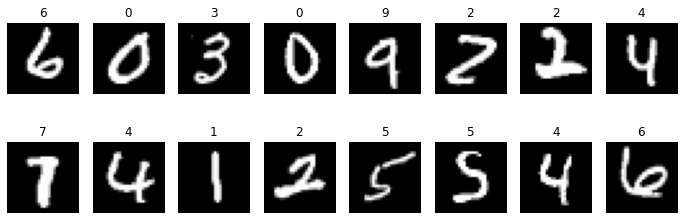

In [6]:
lookat_dataset(data, True)

## Networks architectures

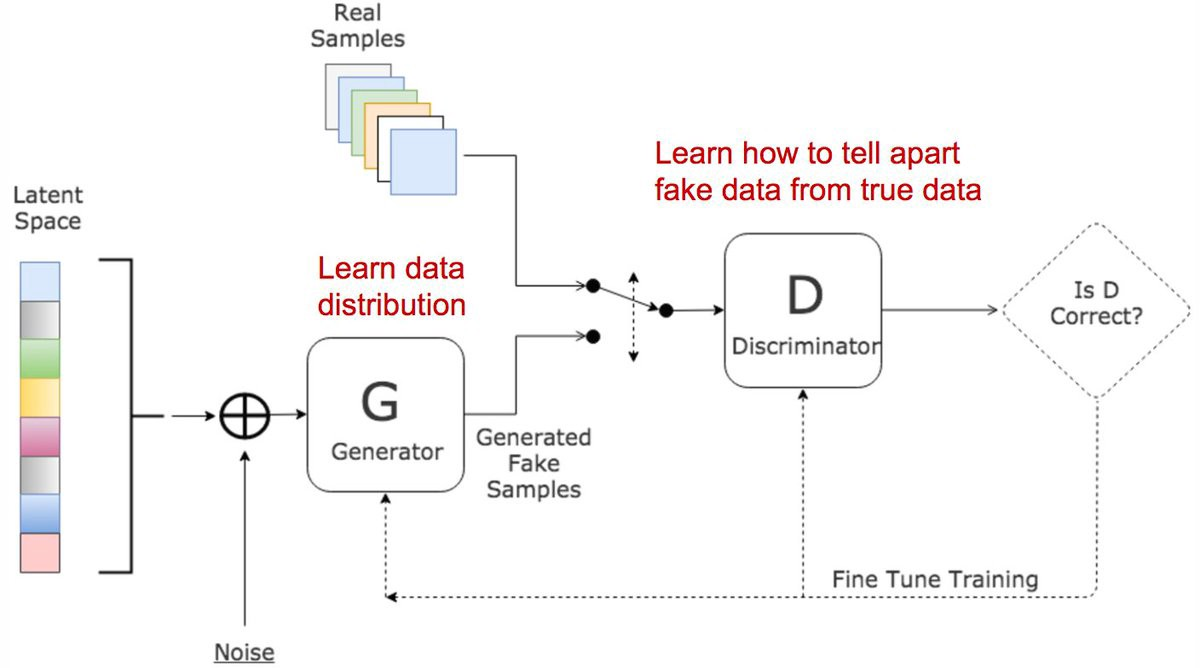

In [7]:
class DiscriminatorNet(nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self, n_in):
        super().__init__()
        n_features = n_in
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
class GeneratorNet(nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_in, n_out):
        super().__init__()
        n_features = n_in
        n_out = n_out
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

Running on cuda


In [11]:
generator_in_features = 100
discriminator_in_features = 28 * 28 # MNIST size

discriminator = DiscriminatorNet(discriminator_in_features).to(device)
generator = GeneratorNet(generator_in_features, discriminator_in_features).to(device)

## Helper functions for visualization and checkpointing

In [20]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Noise
def noise(size):
    n = Variable(torch.randn(size, generator_in_features))
    if torch.cuda.is_available(): return n.cuda() 
    return n

# Visualization
def log_images(test_images, savepath):
  figure = plt.figure(figsize=(8, 8))
  figure.subplots_adjust(wspace=-0.08, hspace=0.01)
  rows, cols = len(test_images)//4, 4
  for i, img in enumerate(test_images):
      figure.add_subplot(rows, cols, i+1)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap='gray')  
  
  figure.savefig(savepath)
  plt.show()
  
def save_models(generator, discriminator, epoch, folder):
  torch.save(generator, os.path.join(folder, f"generator_e{epoch}.pth"))
  torch.save(discriminator, os.path.join(folder, f"discriminator_e{epoch}.pth"))

def load_models(epoch, folder):
  generator = torch.load(os.path.join(folder, f"generator_e{epoch}.pth"))
  discriminator = torch.load(os.path.join(folder, f"discriminator_e{epoch}.pth"))
  return generator, discriminator

def save_losses(g_loss, d_loss, epoch, folder):
  with open(os.path.join(folder, f"gloss_{epoch}.pickle"), 'wb') as f:
    pickle.dump(g_loss, f)
  with open(os.path.join(folder, f"dloss_e{epoch}.pickle"), 'wb') as f:
    pickle.dump(d_loss, f)

def load_losses(epoch, folder):
  with open(os.path.join(folder, f"gloss_{epoch}.pickle"), 'rb') as f:
    g_loss = pickle.load(f)
  with open(os.path.join(folder, f"dloss_e{epoch}.pickle"), 'rb') as f:
    d_loss = pickle.load(f)
  return g_loss, d_loss

### Generate Samples for Testing

In [13]:
num_test_samples = 16
torch.manual_seed(7777)
imagepath = os.path.join(IMG_DIR, f'{0}.jpg')

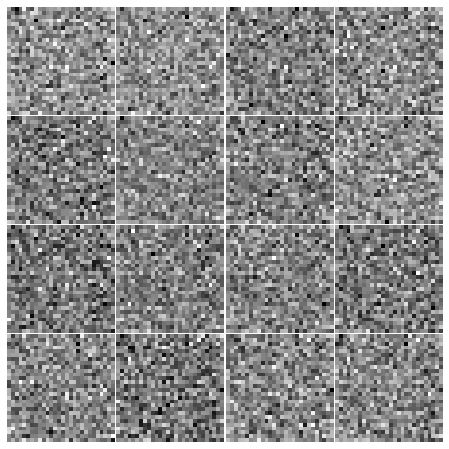

In [15]:
test_noise = noise(num_test_samples)
log_images(vectors_to_images(
                generator(test_noise)).cpu().detach().numpy(), 
                imagepath)

## Optimization hyperparameters

We want to optimize:

$$\begin{align*} 
\min_{G} \max_{D} V(D, G) = E_{x∼p_{data}(x)}[logD(x)] + E_{z∼p_z(z)}[log(1 −D(G(z)))]
\end{align*}$$

In PyTorch, we can implement it in terms of Binary Cross Entropy:

## $$−[y_nlog(\hat{y}_n) +(1−y_n)log(1−\hat{y}_n)]$$


* [BCELoss PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

When we have **real data**, $y_n=1$, $\hat{y_n}=D(x_n)$ and we stay with:

## $$−log(D(x_n)) $$

On the other hand, when we have **fake data**, $y_n=0$, $\hat{y}_n=D(G(z_n))$ and we stay with:

## $$−log(1−D(G(z_n)))$$

In [16]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [17]:
def real_data_target(size, device=device):
    '''
    Tensor containing ones, with shape = size
    '''
    return Variable(torch.ones(size, 1)).to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    return Variable(torch.zeros(size, 1)).to(device)

## Training

In [18]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Start training

In [19]:
last_epoch = 0
checkpoint_rate = 50

D_losses = []
G_losses = []
# if we are resuming the training
if last_epoch > 0:
  generator, discriminator = load_models(last_epoch, MODELS_DIR)
  G_losses, D_losses = load_losses(last_epoch, MODELS_DIR)

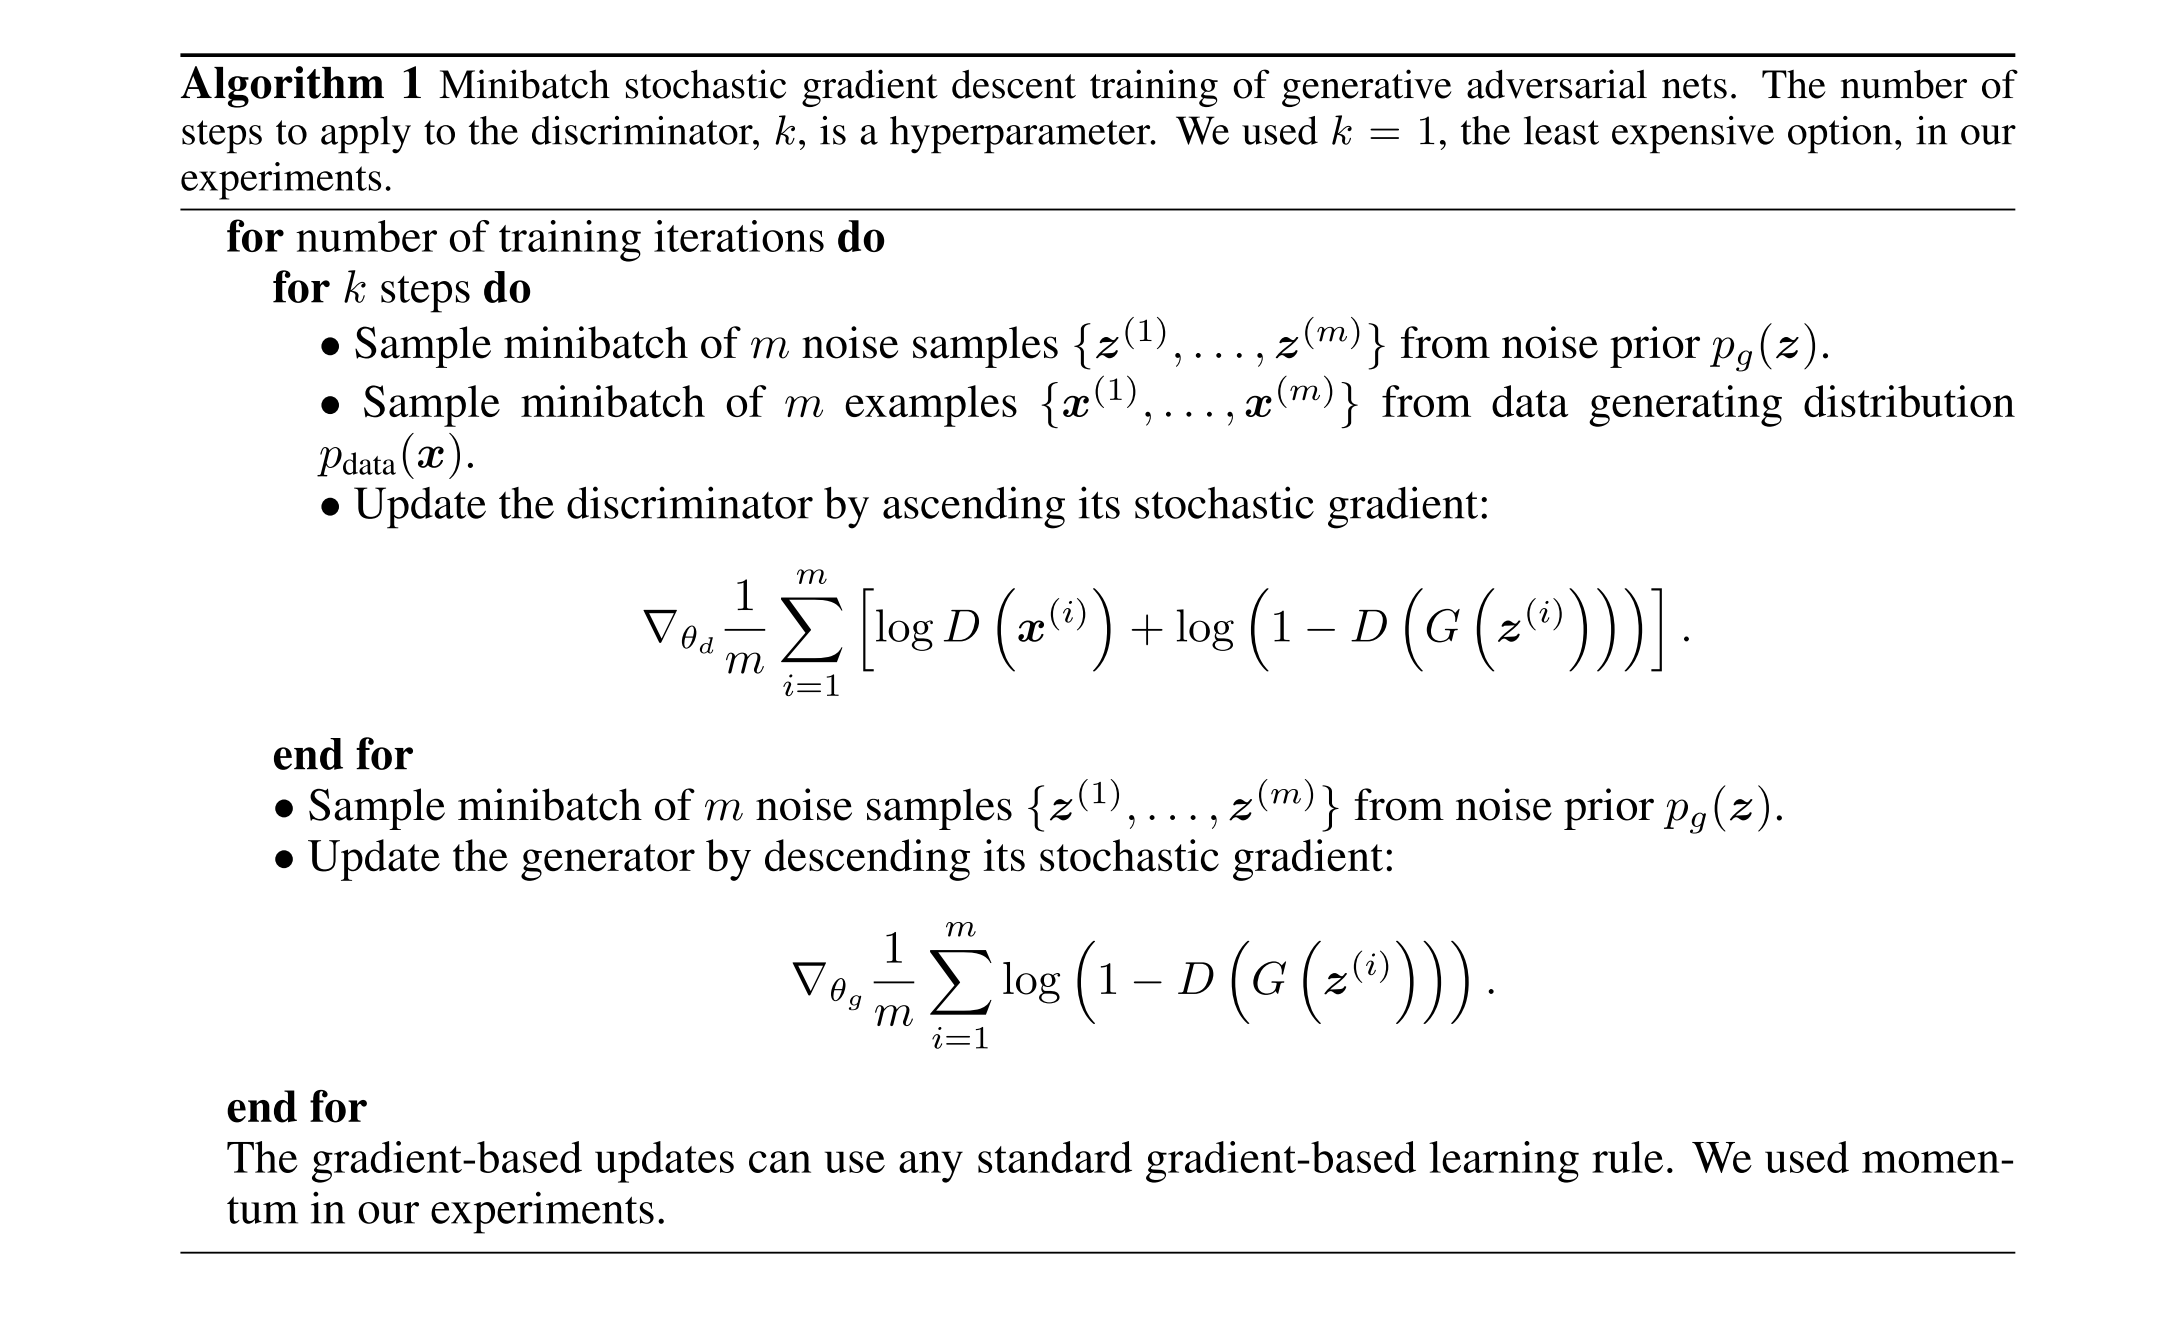

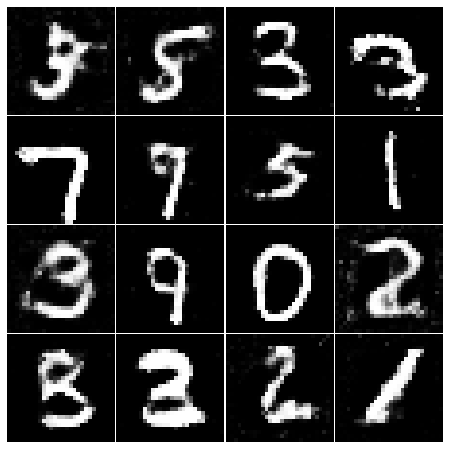

Epoch: 199/200 Losses:
Discriminator: 1.3241; Generator: 0.8778
D(x): 0.5340; D(G(z)): 0.4671


In [21]:
for epoch in range(last_epoch, num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch)).to(device)
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

    display.clear_output(True)
    # Show generated images
    imagepath = os.path.join(IMG_DIR, f'{epoch+1}.jpg')
    test_images = vectors_to_images(generator(test_noise)).cpu().detach().numpy()
    log_images(test_images, imagepath)
    
    # Display status Logs
    G_losses.append(g_error)
    D_losses.append(d_error)
    print(f"Epoch: {epoch}/{num_epochs} Losses:")
    print(f"Discriminator: {d_error:.4f}; Generator: {g_error:.4f}")
    print(f"D(x): {d_pred_real.mean():.4f}; D(G(z)): {d_pred_fake.mean():.4f}")
    
    if (epoch+1) % checkpoint_rate == 0:
        # Save model checkpoints
        save_models(generator, discriminator, epoch, MODELS_DIR) 
        save_losses(G_losses, D_losses, epoch, MODELS_DIR)

# Visualizing the results

In [24]:
def plot_losses(losses):
  fig = plt.figure(figsize=(16, 8))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    loss_values = [k.item() for k in loss_values]  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

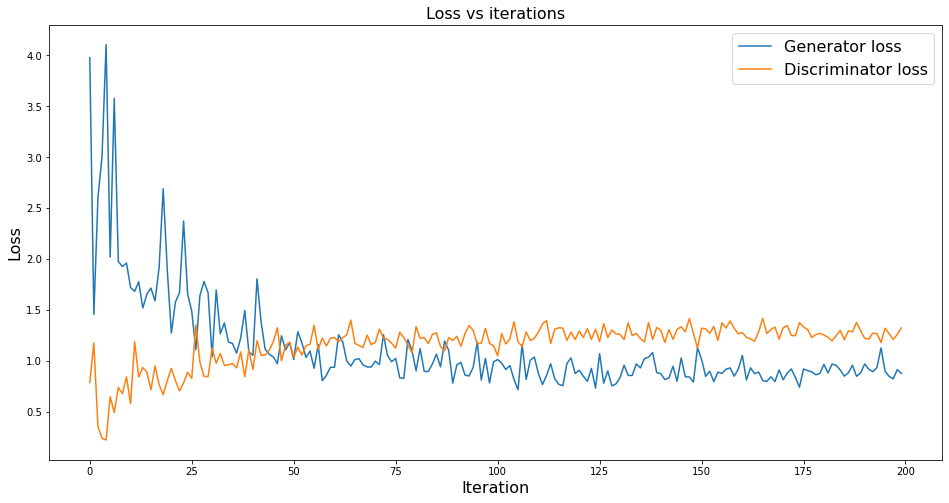

In [25]:
losses = {"Generator loss": G_losses, "Discriminator loss": D_losses}
plot_losses(losses)

## Let's make a GIF of the training process

In [26]:
import imageio

In [27]:
images = []
for filename in sorted(os.listdir(IMG_DIR), key = lambda x: float(x.split('.')[0])):
    if filename.endswith('.jpg'):
        filepath = os.path.join(IMG_DIR, filename)
        images.append(imageio.imread(filepath))
imageio.mimsave(os.path.join(OUTPUT_DIR, 'GAN_training.gif'), images)